In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-06-17 08:55:42.470483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750130742.480075   29112 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750130742.483068   29112 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 08:55:42.493784: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Normalized features

In [2]:


# Define the path to your dataset
dataset_path = "/home/muzaffar/Desktop/Research/papers/02-paperhybrid-word-spken-paper(ablation)/10-words/original-data-3630"

# Initialize lists to hold features and labels
feature_list = []
label_list = []

# Define a function to normalize the mel spectrogram
def normalize_mel_spectrogram(mel_spectrogram):
    mel_spectrogram_db = librosa.power_to_db(S=mel_spectrogram, ref=1.0)
    return (mel_spectrogram_db - np.mean(mel_spectrogram_db)) / np.std(mel_spectrogram_db)

# Define a fixed size for padding (e.g., 128 time steps)
fixed_size = 32

# Update the feature extraction process
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)

    for file in tqdm(os.listdir(class_path)):
        if not file.endswith('.wav'):
            continue

        audio_path = os.path.join(class_path, file)
        audio, sr = librosa.load(path=audio_path, sr=None)
        
        # Avoid using time_stretch unless intended
        # audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)

        mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
        normalized_mels = normalize_mel_spectrogram(mels)

        # Pad or truncate to fixed size
        if normalized_mels.shape[1] < fixed_size:
            # Pad with zeros
            pad_width = fixed_size - normalized_mels.shape[1]
            padded_mels = np.pad(normalized_mels, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate to fixed size
            padded_mels = normalized_mels[:, :fixed_size]

        feature_list.append(padded_mels.T)
        label_list.append(class_folder)

# Convert to NumPy arrays
features = np.array(feature_list)
labels = np.array(label_list)

print("Feature shape:", features.shape)
print("Label shape:", labels.shape)


100%|██████████| 364/364 [00:00<00:00, 390.73it/s]

Feature shape: (3630, 32, 128)
Label shape: (3630,)


In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set parameters for data splitting and training
TEST_SIZE = 0.2
RANDOM_STATE = 42  # For reproducibility

# Encode Labels (from strings to integers)
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)

# One-hot encode the integer labels
encoded_labels = tf.one_hot(indices=integer_labels, depth=len(label_encoder.classes_))

from sklearn.model_selection import train_test_split

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    encoded_labels.numpy(), 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=integer_labels  # Stratify ensures balanced splits for each class
)


print("Train, validation, and test data prepared successfully.")


I0000 00:00:1750130753.624670   29112 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 120 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0b:00.0, compute capability: 6.1


Train, validation, and test data prepared successfully.


In [4]:
features[1].shape

(32, 128)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def evaluate_knn_neighbors(X_train, y_train, X_test, y_test, neighbor_values=[1, 3, 5, 7, 9, 11, 13]):
    """
    Trains KNN classifiers with different n_neighbors and plots test accuracy.

    Parameters:
    - X_train, X_test: Flattened input features
    - y_train, y_test: Integer-encoded labels (not one-hot)
    - neighbor_values: List of k values to test
    """
    accuracies = []

    print("Evaluating KNN with various 'n_neighbors'...\n")

    for k in neighbor_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        print(f"n_neighbors = {k} → Accuracy = {acc:.4f}")

    # Plotting the results
    plt.figure(figsize=(8, 5))
    plt.plot(neighbor_values, accuracies, marker='o', linestyle='-', color='blue')
    plt.title('KNN Accuracy vs. Number of Neighbors')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(neighbor_values)
    plt.show()

    return neighbor_values, accuracies


In [6]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)


Evaluating KNN with various 'n_neighbors'...

n_neighbors = 1 → Accuracy = 0.5716
n_neighbors = 3 → Accuracy = 0.5565
n_neighbors = 5 → Accuracy = 0.5813
n_neighbors = 7 → Accuracy = 0.5730
n_neighbors = 9 → Accuracy = 0.5716
n_neighbors = 11 → Accuracy = 0.5702
n_neighbors = 13 → Accuracy = 0.5730


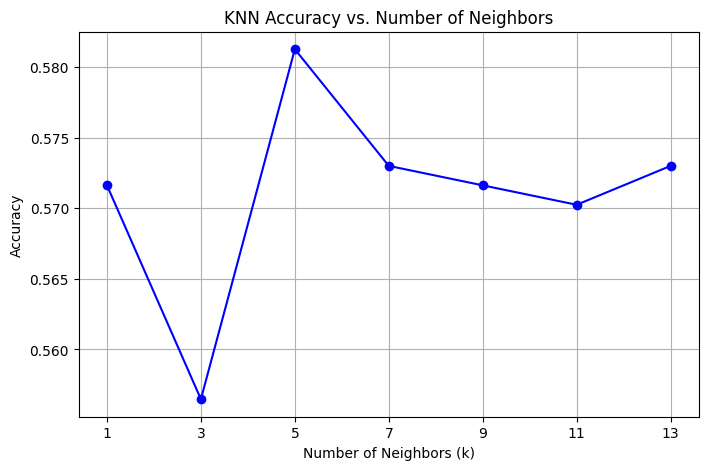

In [7]:
k_vals, accs = evaluate_knn_neighbors(X_train_flat, y_train_int, X_test_flat, y_test_int)
